In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda, BatchNormalization, Activation, Dropout, concatenate
from tensorflow.keras.losses import mse
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.losses import mse, binary_crossentropy

from IPython.display import SVG

from tensorflow.keras import backend as K
from tensorflow.python.keras.callbacks import TensorBoard

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

parallelization_factor = 5

config = tf.ConfigProto(inter_op_parallelism_threads=parallelization_factor,
                      intra_op_parallelism_threads=parallelization_factor)
sess = tf.Session(config=config)

config.gpu_options.allow_growth=True

## Load BRCA labelled data and Full TCGA data

In [2]:
X_brca_train = pd.read_pickle("../data/tcga_brca_raw_19036_row_log_norm_train.pkl")
X_tcga_no_labelled_brca = pd.read_pickle("../data/tcga_raw_no_labelled_brca_log_row_normalized.pkl")
X_tcga_type_no_labelled_brca = pd.read_pickle("../data/tcga_raw_tumor_type.pkl")

### Preprocess BRCA labelled data

In [3]:
y_brca_train = X_brca_train["Ciriello_subtype"]
X_brca_train.drop(['tcga_id', 'Ciriello_subtype', 'sample_id', 'cancer_type'], axis="columns", inplace=True)

scaler = MinMaxScaler()
X_autoencoder = X_tcga_no_labelled_brca
X_autoencoder_scaled = pd.DataFrame(scaler.fit_transform(X_autoencoder), columns=X_autoencoder.columns)

## Initialize variables and hyperparameters

In [4]:
original_dim = X_autoencoder_scaled.shape[1]
input_shape = (original_dim,)
intermediate_dim = 300
latent_dim = 100

batch_size = 50
epochs = 100
learning_rate = 0.001

dropout_rate_input = 0.6
dropout_rate_hidden = 0.6

cond_dim = 33

## Define functions

In [5]:
def sampling(args):
    
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def vae_loss(y_true, y_pred):
    # E[log P(X|z)]
    reconstruction_loss = original_dim * binary_crossentropy(y_true, y_pred) # because it returns the mean cross-entropy
    # reconstruction_loss = mse(y_true, y_pred)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl_loss = -0.5 * K.sum(1. + z_log_var_encoded - K.exp(z_log_var_encoded) - K.square(z_mean_encoded), axis=1)

    return K.mean(reconstruction_loss + kl_loss)

## Build Encoder

In [7]:
input_data = Input(shape=(original_dim, ))
input_cond = Input(shape=(cond_dim, ))

inputs = concatenate([input_data, input_cond])

input_dropout = Dropout(rate=dropout_rate_input)(inputs)

hidden_dense = Dense(intermediate_dim)(input_dropout)
hidden_dense_batchnorm = BatchNormalization()(hidden_dense)
hidden_dense_encoded = Activation("relu")(hidden_dense_batchnorm)
z_mean_dense = Dense(latent_dim, name="z_mean_dense")(hidden_dense_encoded)
z_log_var_dense = Dense(latent_dim, name="z_log_var_dense")(hidden_dense_encoded)

# Latent representation layers
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense)
z_mean_encoded = Activation("relu")(z_mean_dense_batchnorm)

z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense)
z_log_var_encoded = Activation("relu")(z_log_var_dense_batchnorm)

# Sample z
z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean_encoded, z_log_var_encoded])
z_cond = concatenate([z, input_cond])

encoder = Model([input_data, input_cond], [z_mean_encoded, z_log_var_encoded], name="encoder")
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 19036)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 19069)        0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 19069)        0           concatenate_2[0][0]              
__________

In [9]:
encoder_get_embedding = Model([input_data, input_cond], z, name="encoder_get_embedding")
encoder_get_embedding.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 19036)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 19069)        0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 19069)        0           concatenate_2[0][0]              
__________

## Build Decoder 

In [10]:
decoder_hidden = Dense(intermediate_dim, activation="relu", name="decoder_hidden")
decoder_output = Dense(original_dim, activation="sigmoid", name="decoder_output")

vae_decoder_hidden = decoder_hidden(z)

decoder_dropout = Dropout(rate=dropout_rate_hidden)
decoder_hidden_dropout = decoder_dropout(vae_decoder_hidden)
outputs = decoder_output(decoder_hidden_dropout)

In [11]:
decoder_hidden = Dense(intermediate_dim, activation="relu", name="decoder_hidden")
decoder_output = Dense(original_dim, activation="sigmoid", name="decoder_output")

vae_decoder_hidden = decoder_hidden(z)
decoder_dropout = Dropout(rate=dropout_rate_hidden)

decoder_hidden_dropout = decoder_dropout(vae_decoder_hidden)
outputs = decoder_output(decoder_hidden_dropout)

## Build Conditional Variational Autoencoder

In [14]:
adam = optimizers.Adam(lr=learning_rate)
cvae = Model([input_data, input_cond], outputs, name='cvae')
cvae.compile(optimizer=adam, loss=vae_loss)
cvae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 19036)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 19069)        0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 19069)        0           concatenate_2[0][0]              
__________

## Train the Model

In [18]:
X_autoencoder_train, X_autoencoder_val, X_autoencoder_tumor_type_train, X_autoencoder_tumor_type_val = train_test_split(X_autoencoder_scaled, X_tcga_type_no_labelled_brca, test_size=0.1, stratify=X_tcga_type_no_labelled_brca, random_state=42)

In [19]:
type(X_autoencoder_val)

pandas.core.frame.DataFrame

In [21]:
fit_hist = cvae.fit([X_autoencoder_train, pd.get_dummies(X_autoencoder_tumor_type_train)], X_autoencoder_train,
                        shuffle=True,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
                        validation_data=([X_autoencoder_val, pd.get_dummies(X_autoencoder_tumor_type_val)], X_autoencoder_val))

Train on 8358 samples, validate on 929 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
8358/8358 [==============================] - 36s 4ms/sample - loss: 10351.5668 - val_loss: 10077.4234
Epoch 2/100
8358/8358 [==============================] - 31s 4ms/sample - loss: 10050.6725 - val_loss: 9942.2014
Epoch 3/100
8358/8358 [==============================] - 30s 4ms/sample - loss: 10006.7409 - val_loss: 9905.7593
Epoch 4/100
8358/8358 [==============================] - 31s 4ms/sample - loss: 9985.6364 - val_loss: 9876.0342
Epoch 5/100
8358/8358 [==============================] - 28s 3ms/sample - loss: 9972.9151 - val_loss: 9864.6476
Epoch 6/100
8358/8358 [==============================] - 28s 3ms/sample - loss: 9961.1385 - val_loss: 9857.6335
Epoch 7/100
8358/8358 [==============================] - 29s 3ms/sample - loss: 9954.2110 - val_loss: 9847.1678
Epoch 8/100
8358/8358 [==============================] - 28s 3ms/sample - loss: 9947.5438 - val_loss: 9837.9844
Epoch

## Visualize training performance

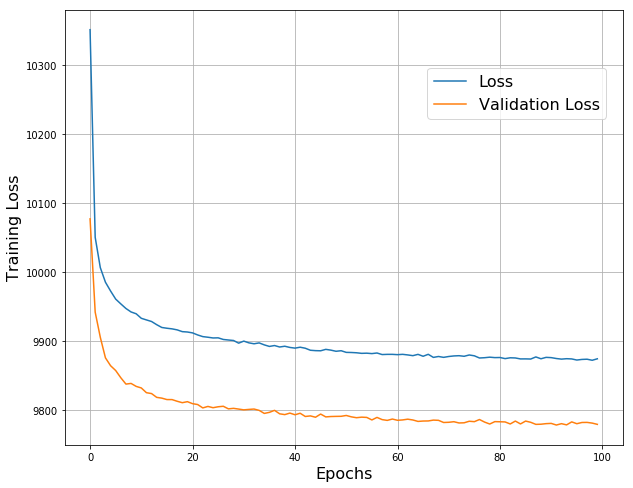

In [23]:
import matplotlib.font_manager

history_df = pd.DataFrame(fit_hist.history)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
loss_plot, = ax.plot(fit_hist.history['loss'])
val_loss_plot, = ax.plot(fit_hist.history['val_loss'])
ax.set_xlabel('Epochs', fontsize = 16, fontname='Times New Roman')
ax.set_ylabel('Training Loss', fontsize = 16, fontname='Times New Roman')

leg = ax.legend((loss_plot, val_loss_plot),
           ('Loss', 'Validation Loss'),
           scatterpoints=1,
           markerscale=2.5,
           loc=(0.65,0.75),
           ncol=1,
           fontsize=16)

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.grid()

In [24]:
fig.savefig("../figures/cvae_training_history_tcga.pdf", bbox_inches='tight')

### Get the embedding of the BRCA training data

In [25]:
X_brca_train_scaled = pd.DataFrame(scaler.fit_transform(X_brca_train), columns=X_brca_train.columns)

In [28]:
tumors = X_autoencoder_tumor_type_train["tumor_type"].unique()
X_brca_train_tumor_type = pd.DataFrame(0, index=np.arange(len(X_brca_train_scaled)), columns=tumors)
X_brca_train_tumor_type["BRCA"]=1
embeddings_before_class = encoder_get_embedding.predict([X_brca_train_scaled, X_brca_train_tumor_type])

In [29]:
embeddings_before_class

array([[-1.3190405 ,  1.4435201 ,  0.68186754, ...,  1.1732341 ,
        -0.11392205,  2.1944156 ],
       [-0.4451705 , -0.9194427 , -0.20122965, ..., -0.1723479 ,
         0.33615524,  0.9277531 ],
       [ 1.7892721 ,  0.73221016, -0.6783203 , ...,  0.0436032 ,
         0.6586126 ,  1.6753381 ],
       ...,
       [ 0.11105165,  3.852643  ,  2.1586576 , ..., -0.098447  ,
         0.13181265,  1.319358  ],
       [-1.0254288 , -0.94507277,  1.2881762 , ..., -0.63424385,
         0.324782  ,  1.0586367 ],
       [ 0.37717843, -1.0194601 , -0.09982455, ...,  0.6161133 ,
         0.4134455 ,  1.0322679 ]], dtype=float32)

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings_before_class)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_brca_train], axis="columns")

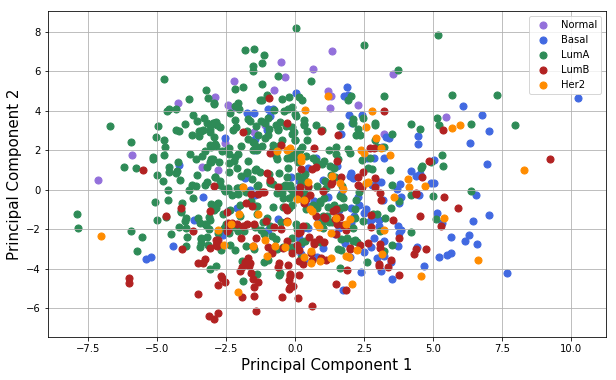

In [31]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets = ['Normal', 'Basal', 'LumA', 'LumB', 'Her2']
colors = ['mediumpurple', 'royalblue', 'seagreen', 'firebrick', 'darkorange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Ciriello_subtype'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [32]:
fig.savefig("../figures/cvae_embedding_before_classifier_tcga.pdf", bbox_inches='tight')

### Now we stack the classifier and train it with the BRCA labeled samples

In [34]:
classifier_output = Dense(5, activation="softmax", name="classifier_output")(concatenate([z_mean_encoded, z_log_var_encoded], axis=1))

classifier = Model([input_data, input_cond], classifier_output, name="classifier")
adam = optimizers.Adam(lr=learning_rate)
classifier.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 19036)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 19069)        0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 19069)        0           concatenate_2[0][0]              
__________

In [39]:
enc = OneHotEncoder(sparse=False)
y_brca_train_onehot = enc.fit_transform(y_brca_train.values.reshape(-1, 1))

X_train_train, X_train_val, y_labels_train_train, y_labels_train_val = train_test_split(X_brca_train_scaled, y_brca_train_onehot, test_size=0.2, stratify=y_brca_train, random_state=42)


X_train_train_tumor_type = pd.DataFrame(0, index=np.arange(len(X_train_train)), columns=tumors)
X_train_train_tumor_type["BRCA"]=1
X_train_val_tumor_type = pd.DataFrame(0, index=np.arange(len(X_train_val)), columns=tumors)
X_train_val_tumor_type["BRCA"]=1

fit_hist = classifier.fit(x=[X_train_train, X_train_train_tumor_type], 
                                y=y_labels_train_train, 
                                shuffle=True, 
                                epochs=100,
                                batch_size=50,
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                                validation_data=([X_train_val, X_train_val_tumor_type], y_labels_train_val))

Train on 653 samples, validate on 164 samples
Epoch 1/100
653/653 [==============================] - 2s 3ms/sample - loss: 1.3395 - acc: 0.4885 - val_loss: 0.9906 - val_acc: 0.6159
Epoch 2/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.8813 - acc: 0.6876 - val_loss: 0.8524 - val_acc: 0.6707
Epoch 3/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.7213 - acc: 0.7534 - val_loss: 0.7683 - val_acc: 0.7012
Epoch 4/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.6375 - acc: 0.7825 - val_loss: 0.6742 - val_acc: 0.7317
Epoch 5/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.5841 - acc: 0.7887 - val_loss: 0.6305 - val_acc: 0.7439
Epoch 6/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.5244 - acc: 0.8147 - val_loss: 0.5473 - val_acc: 0.7561
Epoch 7/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.4905 - acc: 0.8239 - val_loss: 0.5376 - val_acc: 0.7561
Epoch 8/1

### Get embeddings after training the classifier and plot PCA

In [40]:
embeddings_after = encoder_get_embedding.predict([X_brca_train_scaled, X_brca_train_tumor_type])

In [41]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings_after)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_brca_train], axis="columns")

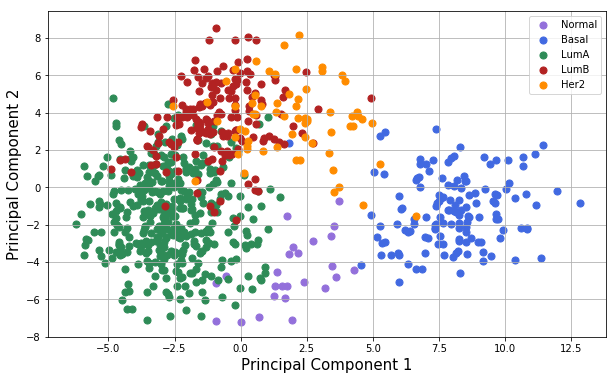

In [42]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets = ['Normal', 'Basal', 'LumA', 'LumB', 'Her2']
colors = ['mediumpurple', 'royalblue', 'seagreen', 'firebrick', 'darkorange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Ciriello_subtype'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [43]:
fig.savefig("../figures/cvae_embedding_after_classifier_tcga.pdf", bbox_inches='tight')